<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-1-Data-Preprocessing" data-toc-modified-id="Part-1-Data-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Part 1 Data Preprocessing</a></span></li><li><span><a href="#Part-2-Graphs" data-toc-modified-id="Part-2-Graphs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part 2 Graphs</a></span></li><li><span><a href="#Part-3-AdaBoost" data-toc-modified-id="Part-3-AdaBoost-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Part 3 AdaBoost</a></span></li><li><span><a href="#Part-4-(SVM)" data-toc-modified-id="Part-4-(SVM)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Part 4 (SVM)</a></span><ul class="toc-item"><li><span><a href="#Plotting-Decision-Boundries" data-toc-modified-id="Plotting-Decision-Boundries-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Plotting Decision Boundries</a></span></li><li><span><a href="#Hyperparameter-Tuning" data-toc-modified-id="Hyperparameter-Tuning-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Hyperparameter Tuning</a></span></li><li><span><a href="#Hard-Voting-Classifiers" data-toc-modified-id="Hard-Voting-Classifiers-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Hard Voting Classifiers</a></span></li><li><span><a href="#Convex-Optimization" data-toc-modified-id="Convex-Optimization-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Convex Optimization</a></span></li></ul></li></ul></div>

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import median, mode
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix
from sklearn.datasets.samples_generator import make_circles
from mlxtend.plotting import plot_decision_regions
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from cvxopt import matrix, solvers

## Part 1 Data Preprocessing
Replace all the nan values in "PH" feature using "sulphates" feature. 

In [2]:
data1 = pd.read_csv('JuiceQuality.csv')
data1.head()
map = {
    'low': np.mean(data1[data1['sulphates'] == 'low']['pH']),
    'medium': np.mean(data1[data1['sulphates'] == 'medium']['pH']),
    'high': np.mean(data1[data1['sulphates'] == 'high']['pH']),
    'very_high': np.mean(data1[data1['sulphates'] == 'very_high']['pH']),
    'nan': np.mean(data1[np.isnan(data1['pH']) == False]['pH'])
}
data1['pH'] = data1.apply(lambda i: map[str(i['sulphates'])] if math.isnan(i['pH']) else i['pH'], axis=1)
data1.head(10)

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,A Indx,density,pH,sulphates,Vit Indx,quality,Type
0,0,5.9,0.32,0.39,low,0.114,24.0,140.0,13.905151,0.99340,3.090000,low,very_low,high,Lemon_Juice
1,1,7.8,0.24,0.18,high,0.046,33.0,160.0,17.130070,0.99630,3.200000,medium,low,high,Lemon_Juice
2,2,7.7,0.58,0.01,very_low,0.088,12.0,18.0,15.618966,0.99568,3.256431,medium,low,high,Orange_Juice
3,3,8.3,0.18,0.30,very_low,0.033,20.0,57.0,18.085322,0.99109,3.020000,medium,medium,high,Lemon_Juice
4,4,6.5,NaN,0.31,very_low,0.044,NaN,127.0,13.968160,0.99280,3.490000,low,low,high,Lemon_Juice
5,5,7.4,NaN,0.28,NaN,0.032,43.0,138.0,NaN,NaN,3.100000,low,low,high,Lemon_Juice
6,6,6.2,0.23,0.38,very_low,0.044,12.0,113.0,14.537886,0.99176,3.300000,medium,medium,low,Lemon_Juice
7,7,6.7,0.29,0.49,NaN,0.034,35.0,156.0,15.143448,0.99450,3.130000,low,low,high,Lemon_Juice
8,8,NaN,NaN,0.43,very_high,0.053,60.0,184.0,19.498960,1.00080,3.280000,medium,very_low,high,Lemon_Juice
9,9,6.4,0.23,0.35,very_high,0.042,54.0,140.0,14.217306,0.99670,3.230000,low,very_low,low,Lemon_Juice


Use Linear Regression to fill out nan values. "A Indx" feature is presumed as a Label and "fixed acidity", "citric acid" and " chlorides" are our features. You can use any of the mentioned features to estimate nan values in Label.

In [3]:
data2 = pd.read_csv('JuiceQuality.csv')
data2train = data2.dropna(subset=['fixed acidity', 'citric acid', 'chlorides', 'A Indx'])
features = [['fixed acidity'], ['citric acid'], ['chlorides'], ['fixed acidity', 'citric acid'], ['fixed acidity', 'chlorides'], ['citric acid', 'chlorides'], ['fixed acidity', 'citric acid', 'chlorides']]
errors = np.zeros(len(features))
index = 0
for feature in features:
    X = data2train.loc[:, feature]
    Y = data2train.loc[:, 'A Indx']
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
    regressor = LinearRegression()
    regressor.fit(Xtrain, Ytrain)
    Ypredict = regressor.predict(Xtest)
    errors[index] = np.sum((Ypredict - Ytest) ** 2) / len(Ytest)
    index = index + 1
best = np.where(errors == min(errors))[0][0]
X = data2train.loc[:, features[best]]
Y = data2train.loc[:, 'A Indx']
regressor = LinearRegression()
regressor.fit(X, Y)
data2[['fixed acidity', 'citric acid', 'chlorides']] = round(data2[['fixed acidity', 'citric acid', 'chlorides']].fillna(data2[['fixed acidity', 'citric acid', 'chlorides']].mean()), 2)
data2['A Indx'] = data2.apply(lambda i: round(regressor.predict([[i[j] for j in features[best]]])[0], 2) if math.isnan(i['A Indx']) else i['A Indx'], axis=1)
print(features[best])
print(errors[best])
data2.head(10)

['fixed acidity', 'citric acid', 'chlorides']
0.10489182246127145


,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,A Indx,density,pH,sulphates,Vit Indx,quality,Type
0,0,5.90,0.32,0.39,low,0.11,24.0,140.0,13.905151,0.99340,3.09,low,very_low,high,Lemon_Juice
1,1,7.80,0.24,0.18,high,0.05,33.0,160.0,17.130070,0.99630,3.20,medium,low,high,Lemon_Juice
2,2,7.70,0.58,0.01,very_low,0.09,12.0,18.0,15.618966,0.99568,NaN,medium,low,high,Orange_Juice
3,3,8.30,0.18,0.30,very_low,0.03,20.0,57.0,18.085322,0.99109,3.02,medium,medium,high,Lemon_Juice
4,4,6.50,NaN,0.31,very_low,0.04,NaN,127.0,13.968160,0.99280,3.49,low,low,high,Lemon_Juice
5,5,7.40,NaN,0.28,NaN,0.03,43.0,138.0,16.290000,NaN,3.10,low,low,high,Lemon_Juice
6,6,6.20,0.23,0.38,very_low,0.04,12.0,113.0,14.537886,0.99176,3.30,medium,medium,low,Lemon_Juice
7,7,6.70,0.29,0.49,NaN,0.03,35.0,156.0,15.143448,0.99450,3.13,low,low,high,Lemon_Juice
8,8,7.21,NaN,0.43,very_high,0.05,60.0,184.0,19.498960,1.00080,3.28,medium,very_low,high,Lemon_Juice
9,9,6.40,0.23,0.35,very_high,0.04,54.0,140.0,14.217306,0.99670,3.23,low,very_low,low,Lemon_Juice


Combination of three features gives best result; but decision mainly is taken based on "fixed acidity" feature.
Square errors on train data and test data can be used as two criteria for suitability evaluation of "A Indx" estimation.

Use the categorial features like "Vit Indx" to estimate nan values in "A Indx" feature. 

In [4]:
data3 = pd.read_csv('JuiceQuality.csv')
map = {
    'residual sugar': {'very_low': 0, 'low': 1, 'medium': 2, 'high': 3,'very_high': 3}, 
    'sulphates': {'low': 0, 'medium': 1, 'high': 2,'very_high': 3},
    'Vit Indx': {'very_low': 0, 'low': 1, 'medium': 2, 'high': 3,'very_high': 3}
}
data3.replace(map, inplace=True)
data3['residual sugar 1'] = data3['residual sugar'] // 2
data3['residual sugar 2'] = data3['residual sugar'] % 2
data3['sulphates 1'] = data3['sulphates'] // 2
data3['sulphates 2'] = data3['sulphates'] % 2
data3['Vit Indx 1'] = data3['Vit Indx'] // 2
data3['Vit Indx 2'] = data3['Vit Indx'] % 2
data3train = data3.dropna(subset=['residual sugar', 'sulphates', 'Vit Indx', 'A Indx'])
features = [['residual sugar 1', 'residual sugar 2'], ['sulphates 1', 'sulphates 2'], ['Vit Indx 1', 'Vit Indx 2']]
errors = np.zeros(len(features))
index = 0
for feature in features:
    X = data3train.loc[:, feature]
    Y = data3train.loc[:, 'A Indx']
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
    regressor = LinearRegression()
    regressor.fit(Xtrain, Ytrain)
    Ypredict = regressor.predict(Xtest)
    errors[index] = np.sum((Ypredict - Ytest) ** 2) / len(Ytest)
    index = index + 1
best = np.where(errors == min(errors))[0][0]
X = data3train.loc[:, features[best]]
Y = data3train.loc[:, 'A Indx']
regressor = LinearRegression()
regressor.fit(X, Y)
data3[['residual sugar 1', 'residual sugar 2', 'sulphates 1', 'sulphates 2', 'Vit Indx 1', 'Vit Indx 2']] = round(data3[['residual sugar 1', 'residual sugar 2', 'sulphates 1', 'sulphates 2', 'Vit Indx 1', 'Vit Indx 2']].fillna(data3[['residual sugar 1', 'residual sugar 2', 'sulphates 1', 'sulphates 2', 'Vit Indx 1', 'Vit Indx 2']].mean()), 0)
data3['A Indx'] = data3.apply(lambda i: round(regressor.predict([[i[j] for j in features[best]]])[0], 2) if math.isnan(i['A Indx']) else i['A Indx'], axis=1)
print(features[best])
print(errors[best])
data3.head(10)

['sulphates 1', 'sulphates 2']
8.03432844350388


,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,A Indx,density,...,sulphates,Vit Indx,quality,Type,residual sugar 1,residual sugar 2,sulphates 1,sulphates 2,Vit Indx 1,Vit Indx 2
0,0,5.9,0.32,0.39,1.0,0.114,24.0,140.0,13.905151,0.99340,...,0.0,0.0,high,Lemon_Juice,0.0,1.0,0.0,0.0,0.0,0.0
1,1,7.8,0.24,0.18,3.0,0.046,33.0,160.0,17.130070,0.99630,...,1.0,1.0,high,Lemon_Juice,1.0,1.0,0.0,1.0,0.0,1.0
2,2,7.7,0.58,0.01,0.0,0.088,12.0,18.0,15.618966,0.99568,...,1.0,1.0,high,Orange_Juice,0.0,0.0,0.0,1.0,0.0,1.0
3,3,8.3,0.18,0.30,0.0,0.033,20.0,57.0,18.085322,0.99109,...,1.0,2.0,high,Lemon_Juice,0.0,0.0,0.0,1.0,1.0,0.0
4,4,6.5,NaN,0.31,0.0,0.044,NaN,127.0,13.968160,0.99280,...,0.0,1.0,high,Lemon_Juice,0.0,0.0,0.0,0.0,0.0,1.0
5,5,7.4,NaN,0.28,NaN,0.032,43.0,138.0,15.400000,NaN,...,0.0,1.0,high,Lemon_Juice,0.0,1.0,0.0,0.0,0.0,1.0
6,6,6.2,0.23,0.38,0.0,0.044,12.0,113.0,14.537886,0.99176,...,1.0,2.0,low,Lemon_Juice,0.0,0.0,0.0,1.0,1.0,0.0
7,7,6.7,0.29,0.49,NaN,0.034,35.0,156.0,15.143448,0.99450,...,0.0,1.0,high,Lemon_Juice,0.0,1.0,0.0,0.0,0.0,1.0
8,8,NaN,NaN,0.43,3.0,0.053,60.0,184.0,19.498960,1.00080,...,1.0,0.0,high,Lemon_Juice,1.0,1.0,0.0,1.0,0.0,0.0
9,9,6.4,0.23,0.35,3.0,0.042,54.0,140.0,14.217306,0.99670,...,0.0,0.0,low,Lemon_Juice,1.0,1.0,0.0,0.0,0.0,0.0


If values 0, 1, 2, 3 is used, the hypothesis class will be more limited and can only classify based on a real number; but with this method more options are available.
"sulphates" features has the best estimation
According to results, performance of this method is acceptable

## Part 2 Graphs
Mean, Variance, Mode and Median

In [5]:
data = pd.read_csv('JuiceQuality.csv')
low_data = data.loc[data['quality'] == 'low']
high_data = data.loc[data['quality'] == 'high']
properties = ['volatile acidity', 'citric acid', 'A Indx', 'pH']
statistics = []
for i in properties:
    statistics.append([np.mean(data[i]), np.var(data[i]), mode(data[i]), median(data[i])])
statistics = pd.DataFrame(data=statistics, index=['volatile acidity', 'citric acid', 'A Indx', 'pH'], columns=['Mean', 'Variance', 'Mode', 'Median'])
print('all data')
print(statistics, '\r\n')
low_statistics = []
for i in properties:
    low_statistics.append([np.mean(low_data[i]), np.var(low_data[i]), mode(low_data[i]), median(low_data[i])])
low_statistics = pd.DataFrame(data=low_statistics, index=['volatile acidity', 'citric acid', 'A Indx', 'pH'], columns=['Mean', 'Variance', 'Mode', 'Median'])
print('low quality')
print(low_statistics, '\r\n')
high_statistics = []
for i in properties:
    high_statistics.append([np.mean(high_data[i]), np.var(high_data[i]), mode(high_data[i]), median(high_data[i])])
high_statistics = pd.DataFrame(data=high_statistics, index=['volatile acidity', 'citric acid', 'A Indx', 'pH'], columns=['Mean', 'Variance', 'Mode', 'Median'])
print('high quality')
print(high_statistics)

all data
                       Mean  Variance       Mode     Median
volatile acidity   0.339566  0.027073   0.280000   0.460000
citric acid        0.318498  0.020701   0.300000   0.450000
A Indx            16.038616  8.380125  13.905151  16.557703
pH                 3.217659  0.025776   3.160000   3.350000 

low quality
                       Mean  Variance       Mode     Median
volatile acidity   0.398069  0.035611   0.280000   0.280000
citric acid        0.303072  0.026100   0.260000   0.450000
A Indx            16.280450  8.168491  14.537886  12.917978
pH                 3.213126  0.025943   3.140000   3.290000 

high quality
                       Mean  Variance       Mode     Median
volatile acidity   0.305647  0.019110   0.240000   0.290000
citric acid        0.327562  0.017244   0.300000   0.310000
A Indx            15.930852  8.636146  13.905151  16.834942
pH                 3.219294  0.025604   3.200000   3.250000


Mean of "volatile acidity" feature in high quality samples is significantly lower in comparison with same in low quality samples

Plot Bar Graph for the "sulphates" feature for high and low quality juice.

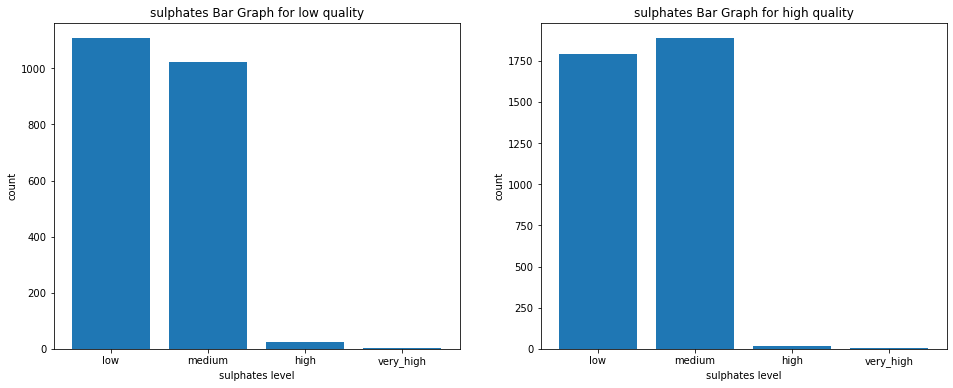

In [6]:
data = pd.read_csv('JuiceQuality.csv')
low_data = data[data['quality'] == 'low']
high_data = data[data['quality'] == 'high']
X = ['low', 'medium', 'high', 'very_high']
low_Y = [len(low_data[low_data['sulphates'] == i]) for i in X]
high_Y = [len(high_data[high_data['sulphates'] == i]) for i in X]
fig = plt.figure(figsize=(16, 6))
fig.add_subplot(121)
plt.bar(X, low_Y)
plt.title('sulphates Bar Graph for low quality')
plt.xlabel('sulphates level')
plt.ylabel('count')
fig.add_subplot(122)
plt.bar(X, high_Y)
plt.title('sulphates Bar Graph for high quality')
plt.xlabel('sulphates level')
plt.ylabel('count')
plt.show()

Plot Box plot for "chlorides" feature for 4 "sulphates" group of labels and two high and low quality juice. 

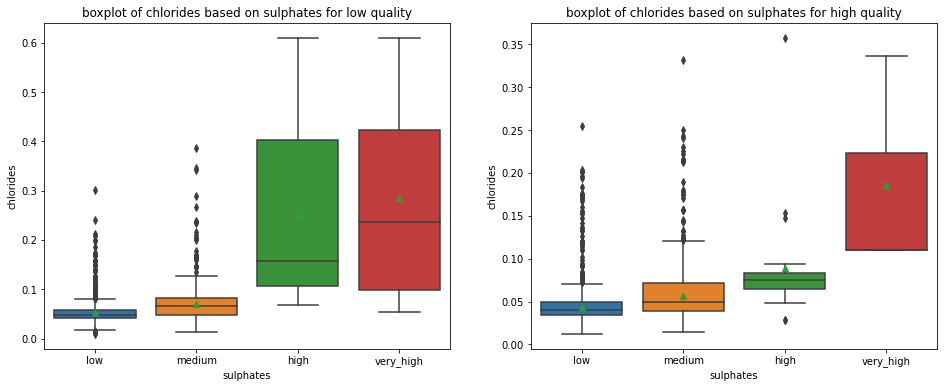

In [7]:
data = pd.read_csv('JuiceQuality.csv').dropna(subset=['sulphates', 'chlorides'])
low_data = data[data['quality'] == 'low']
high_data = data[data['quality'] == 'high']
fig = plt.figure(figsize=(16, 6))
fig.add_subplot(121)
sns.boxplot()
sns.boxplot(x='sulphates', y='chlorides', data=low_data, order=['low', 'medium', 'high', 'very_high'], showmeans=True)
plt.title("boxplot of chlorides based on sulphates for low quality")
fig.add_subplot(122)
sns.boxplot(x='sulphates', y='chlorides', data=high_data, order=['low', 'medium', 'high', 'very_high'], showmeans=True)
plt.title("low quality")
plt.title("boxplot of chlorides based on sulphates for high quality")
plt.show()

Quality of samples that have high "sulphates" feature can be determined based on value of their "chorides" feature

Plot Histogram for "free sulphor dioxide" for hight and low quailty with the distinction of juice type. 

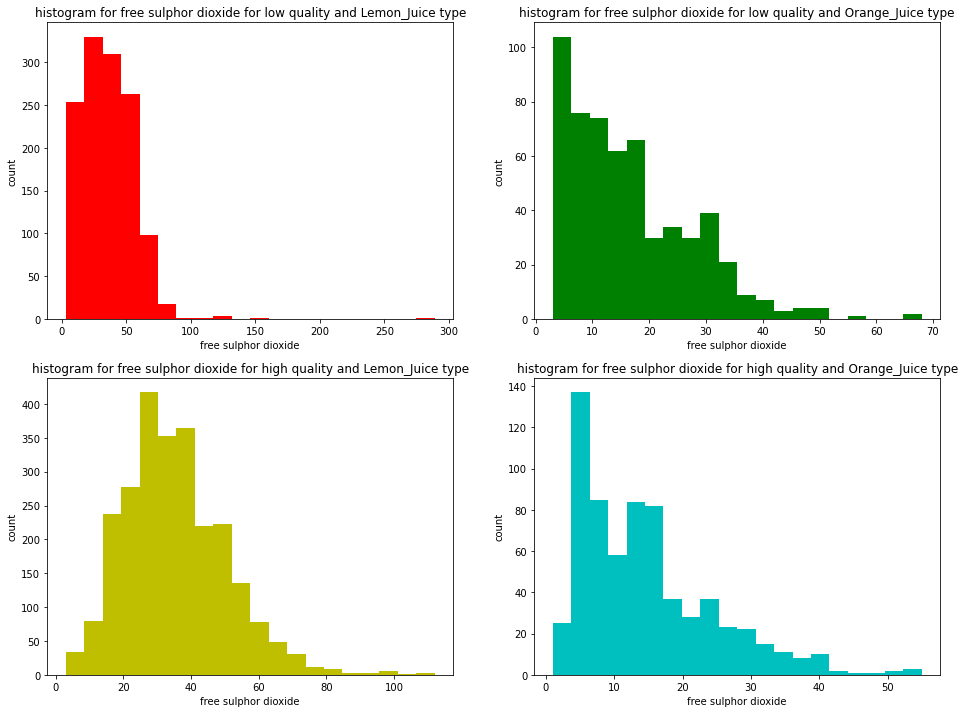

In [8]:
data = pd.read_csv('JuiceQuality.csv').dropna(subset=['sulphates', 'chlorides'])
low_lemon_data = data[(data['quality'] == 'low') & (data['Type'] == 'Lemon_Juice')].dropna(subset=['free sulfur dioxide'])
low_orange_data = data[(data['quality'] == 'low') & (data['Type'] == 'Orange_Juice')].dropna(subset=['free sulfur dioxide'])
high_lemon_data = data[(data['quality'] == 'high') & (data['Type'] == 'Lemon_Juice')].dropna(subset=['free sulfur dioxide'])
high_orange_data = data[(data['quality'] == 'high') & (data['Type'] == 'Orange_Juice')].dropna(subset=['free sulfur dioxide'])
bins = 20
fig = plt.figure(figsize=(16, 12))
fig.add_subplot(221)
plt.hist(low_lemon_data['free sulfur dioxide'], bins, color='r') 
plt.title('histogram for free sulphor dioxide for low quality and Lemon_Juice type')
plt.xlabel('free sulphor dioxide')
plt.ylabel('count')
fig.add_subplot(222)
plt.hist(low_orange_data['free sulfur dioxide'], bins, color='g') 
plt.title('histogram for free sulphor dioxide for low quality and Orange_Juice type')
plt.xlabel('free sulphor dioxide')
plt.ylabel('count')
fig.add_subplot(223)
plt.hist(high_lemon_data['free sulfur dioxide'], bins, color='y')  
plt.title('histogram for free sulphor dioxide for high quality and Lemon_Juice type')
plt.xlabel('free sulphor dioxide')
plt.ylabel('count')
fig.add_subplot(224)
plt.hist(high_orange_data['free sulfur dioxide'], bins, color='c') 
plt.title('histogram for free sulphor dioxide for high quality and Orange_Juice type')
plt.xlabel('free sulphor dioxide')
plt.ylabel('count')
plt.show()

Plot heat map for the first 12 column. Compare the correlation between features. 

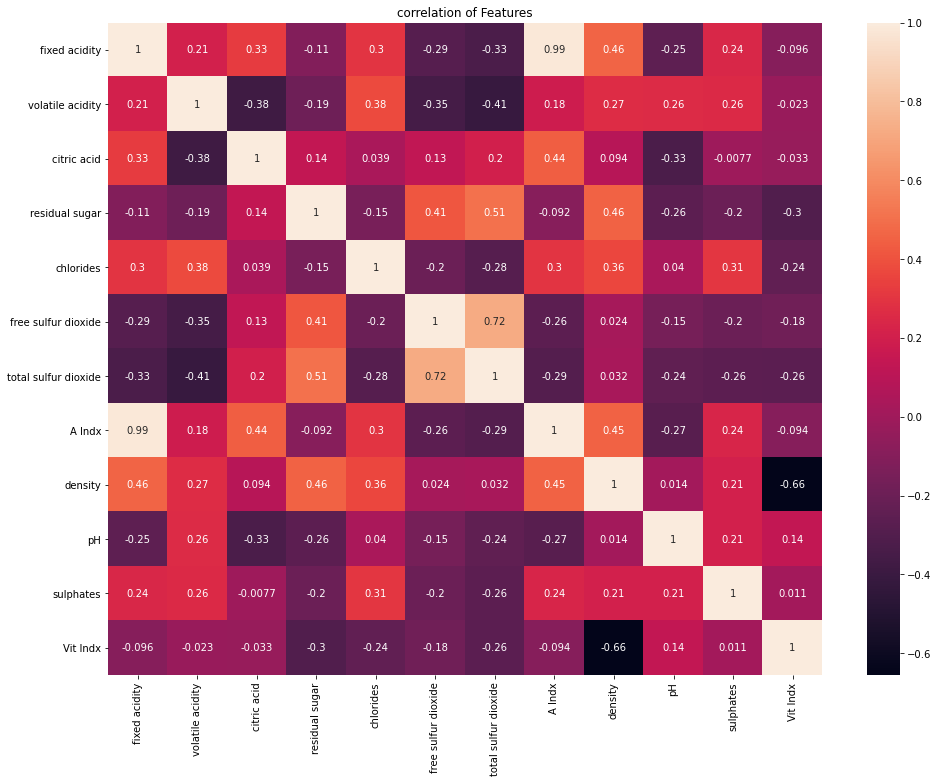

In [9]:
data = pd.read_csv('JuiceQuality.csv').loc[:, 'fixed acidity':'Vit Indx']
map = {
    'residual sugar': {'very_low': 0, 'low': 1, 'medium': 2, 'high': 3,'very_high': 4}, 
    'sulphates': {'low': 0, 'medium': 1, 'high': 2,'very_high': 3},
    'Vit Indx': {'very_low': 0, 'low': 1, 'medium': 2, 'high': 3,'very_high': 4}
}
data.replace(map, inplace=True)
correlation = data.corr()
fig = plt.figure(figsize=(16, 12))
sns.heatmap(correlation, annot=True)
plt.title('correlation of Features')
plt.show()

"fixed acidity" and "A Indx" have high correlation and so one of them can be deleted from dataset

## Part 3 AdaBoost
Use a 5-fold cross validaiton to tune parameters. Utilize DecisionTreeClassifier for the base classifier.
 max_depth must be chosen from {1,3,5} and n_estimators are chosen from {10,50,100,200}. 

In [10]:
data = pd.read_csv('JuiceQuality.csv').loc[:, 'fixed acidity':'quality']
map = {
    'residual sugar': {'very_low': 0, 'low': 1, 'medium': 2, 'high': 3,'very_high': 4}, 
    'sulphates': {'low': 0, 'medium': 1, 'high': 2,'very_high': 3},
    'Vit Indx': {'very_low': 0, 'low': 1, 'medium': 2, 'high': 3,'very_high': 4},
    'quality': {'low': 0, 'high': 1}
}
data.replace(map, inplace=True)
data = data.fillna(round(data.mean(), 2))
X = data.loc[:, 'fixed acidity':'Vit Indx']
Y = data.loc[:, 'quality'].astype(bool)
max_depth = [1, 3, 5]
n_estimators = [10, 50, 100, 200]
models = []
scores = []
for m in max_depth:
    model = []
    score = []
    for n in n_estimators:
        base_estimator = DecisionTreeClassifier(max_depth=m)
        temp = AdaBoostClassifier(base_estimator, n)
        model.append(temp)
        score.append(np.mean(cross_val_score(temp, X, Y)))
    models.append(model)
    scores.append(score)

Report F1 score, accuracy and Confusion matrix for the optimum paramters. 

In [11]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
max_location = np.where(scores == np.amax(scores))
model = models[max_location[0][0]][max_location[1][0]]
model.fit(Xtrain, Ytrain)
Ypredict = model.predict(Xtest)
f1_sc = f1_score(Ypredict, Ytest)
print ("F1_score: {:.2f}".format(f1_sc))
acc_sc = accuracy_score(Ypredict, Ytest)
print ("Accuracy: {:.2f}".format(acc_sc))
confusion_mat = confusion_matrix(Ypredict, Ytest)
print("Confusion matrix:", confusion_mat)

F1_score: 0.81
Accuracy: 0.75
Confusion matrix: [[285 148]
 [175 692]]


Plot the two-class decision scores. Use the decision_function of you classifier. 

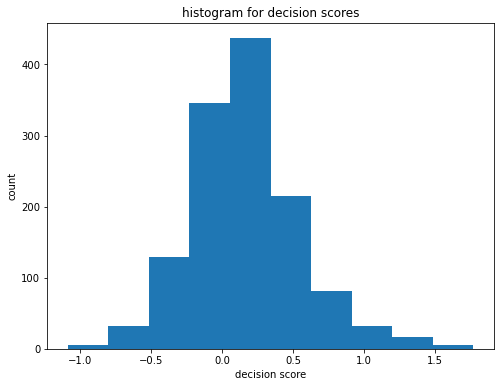

In [12]:
decision_scores = model.decision_function(Xtest)
fig = plt.figure(figsize=(8, 6))
plt.hist(decision_scores)
plt.title('histogram for decision scores')
plt.xlabel('decision score')
plt.ylabel('count')
plt.show()

## Part 4 (SVM)
In this part we are going to feed the preprocessed data (like previous parts) into a SVM classifier. Before that, let us try SVM on a toy dataset (2D), which illustrates two concentric circles, and draw its decision boundries. This is to get a better feeling of how SVM with a kernel function separates nonlinear data. Necessary libraries are imported below. Google them to find out how they are used.
### Plotting Decision Boundries

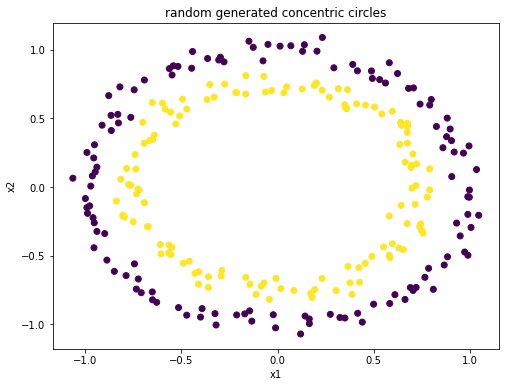

In [13]:
X, Y = make_circles(n_samples=250, noise=0.05, factor=0.75)
fig = plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.title('random generated concentric circles')
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

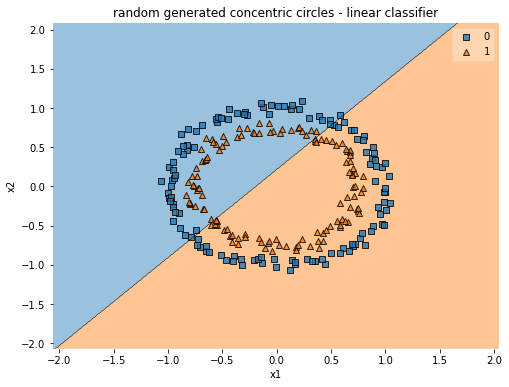

In [14]:
linear_clf = svm.SVC(kernel='linear').fit(X, Y)
fig = plt.figure(figsize=(8, 6))
plot_decision_regions(X, Y, clf=linear_clf)
plt.title('random generated concentric circles - linear classifier')
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

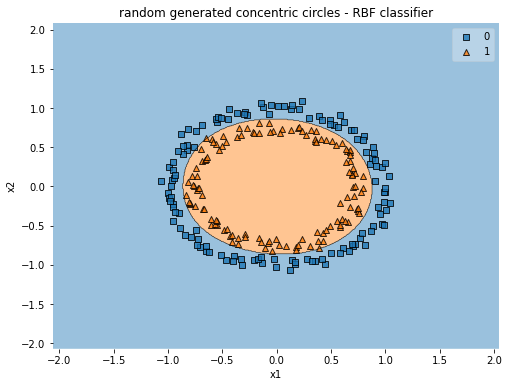

In [15]:
RBF_clf = svm.SVC(kernel='rbf').fit(X, Y)
fig = plt.figure(figsize=(8, 6))
plot_decision_regions(X, Y, clf=RBF_clf)
plt.title('random generated concentric circles - RBF classifier')
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

### Hyperparameter Tuning
There are a wide variety of kernel functions like linear, poly, rbf, and sigmoid. Besides, we need to decide what the value of C (regularization parameter in soft-margin SVM) should be. In case of rbf, there is yet another parameter $\gamma$ that needs to be determined. 

$$Kernel Function \in \{linear, poly, rbf, sigmoid\}$$

$$C \in \{0.1, 1, 10, 100, 1000, 10000\}$$

$$\gamma \in \{0.001, 0.01, 0.1\}$$

Write a function (however you wish) to try all possible combinations (36 overall). Sort them based on their $F_1$ Score, and print then similar to the line below:

Print: #(rank), Classifier, $F_1$ Score, Accuracy, Precision, C, $\gamma$ (empty or NAN if not applicable)<br><br>
Draw the confusion matrix only for the best classifier. 
Please also note that 5-fold cross-validation must be used to estimate the scores.


In [16]:
data = pd.read_csv('JuiceQuality.csv').loc[:, 'fixed acidity':'quality']
map = {
    'residual sugar': {'very_low': 0, 'low': 1, 'medium': 2, 'high': 3,'very_high': 4}, 
    'sulphates': {'low': 0, 'medium': 1, 'high': 2,'very_high': 3},
    'Vit Indx': {'very_low': 0, 'low': 1, 'medium': 2, 'high': 3,'very_high': 4},
    'quality': {'low': 0, 'high': 1}
}
data.replace(map, inplace=True)
data = data.fillna(round(data.mean(), 2))
X = data.loc[:, 'fixed acidity':'Vit Indx']
Y = data.loc[:, 'quality'].astype(bool)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
Cs = [0.01, 0.1]
gammas = [0.01]
info = []
for kernel in kernels:
        for C in Cs:
            if not kernel == 'rbf':
                clf = svm.SVC(C=C, kernel=kernel)
                score = np.mean(cross_val_score(clf, X, Y))
                clf.fit(Xtrain, Ytrain)
                Ypredict = clf.predict(Xtest)
                f1_sc = f1_score(Ypredict, Ytest)
                acc_sc = accuracy_score(Ypredict, Ytest)
                pre_sc = precision_score(Ypredict, Ytest)
                info.append([kernel, f1_sc, acc_sc, pre_sc, score, C, np.nan])
            else:
                for gamma in gammas:
                    clf = svm.SVC(C=C, kernel=kernel, gamma=gamma)
                    score = np.mean(cross_val_score(clf, X, Y))
                    clf.fit(Xtrain, Ytrain)
                    Ypredict = clf.predict(Xtest)
                    f1_sc = f1_score(Ypredict, Ytest)
                    acc_sc = accuracy_score(Ypredict, Ytest)
                    pre_sc = precision_score(Ypredict, Ytest)
                    info.append([kernel, f1_sc, acc_sc, pre_sc, score, C, gamma])
df = pd.DataFrame(data=info, columns=['Classifier', 'F1_Score', 'Accuracy', 'Precision', 'score', 'C', 'gamma'])
f1_socre_sorted_df = df.sort_values(by='F1_Score', ascending=False)
print(f1_socre_sorted_df)
socre_sorted_df = df.sort_values(by='F1_Score', ascending=False)
best = socre_sorted_df.iloc[0, :]
clf = svm.SVC(C=best['C'], kernel=best['Classifier'], gamma=best['gamma'])
clf.fit(Xtrain, Ytrain)
Ypredict = clf.predict(Xtest)
confusion_mat = confusion_matrix(Ypredict, Ytest)
print("Confusion matrix:", confusion_mat)

  Classifier  F1_Score  Accuracy  Precision     score     C  gamma
1     linear  0.796859  0.701538   0.914663  0.707402  0.10    NaN
0     linear  0.781588  0.642308   1.000000  0.657534  0.01    NaN
2       poly  0.780488  0.640000   1.000000  0.653225  0.01    NaN
3       poly  0.780488  0.640000   1.000000  0.653225  0.10    NaN
4        rbf  0.780488  0.640000   1.000000  0.653225  0.01   0.01
6    sigmoid  0.780488  0.640000   1.000000  0.653225  0.01    NaN
5        rbf  0.780075  0.640000   0.997596  0.653533  0.10   0.01
7    sigmoid  0.691578  0.600000   0.700721  0.592888  0.10    NaN
Confusion matrix: [[151  71]
 [317 761]]


### Hard Voting Classifiers

Briefly explain what hard voting (aka majority voting) is. Then perform this classification using Logistic Regression, Decision Trees, and SVM. For more information, visit:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In Hard Voting Classification, each sample X will be classified to the class that receives the largest number
of classifications (or votes)

In [17]:
LR_clf = LogisticRegression()
DT_clf = DecisionTreeClassifier()
SVM_clf = svm.SVC()
voting_clf = VotingClassifier(estimators=[('LR_clf', LR_clf), ('DT_clf', DT_clf), ('SVM_clf', SVM_clf)], voting='hard')
voting_clf.fit(Xtrain, Ytrain)
Ypredict = voting_clf.predict(Xtest)
f1_sc = f1_score(Ypredict, Ytest)
acc_sc = accuracy_score(Ypredict, Ytest)
pre_sc = precision_score(Ypredict, Ytest)
print("F1_score: ", f1_sc)
print("Accuracy: ", acc_sc)
print("Precision: ", pre_sc)

F1_score:  0.804915514592934
Accuracy:  0.7069230769230769
Precision:  0.9447115384615384


### Convex Optimization

We are going to very briefly and easily look at how we go about solving optimization problems that we encounter when solving SVM. Here we use the same quadratic programming (use solvers.qp()) present in the theory problem set 3. Verify your theoretical solutions with Python code.

https://cvxopt.org/


$$min\hspace{3mm} J = (x_1-6)^2+(x_2-6)^2$$

$$s.\hspace{1mm} to \hspace{3mm}2 x_1+4 x_2 \leq 28$$

$$5 x_1 + 5 x_2 \leq 50$$

$$x_1 \leq 8$$

$$x_2 \leq 6$$

$$x_1 \geq 0$$

$$x_2 \geq 0$$

In [18]:
P = matrix([[2.0, 0.0], [0.0, 2.0]])
q = matrix([-12.0, -12.0])
G = matrix([[1.0, 1.0, 1.0, 0.0, -1.0, 0.0], [2.0, 1.0, 0.0, 1.0, 0.0, -1.0]])
h = matrix([14.0, 10.0, 8.0, 6.0, 0.0, 0.0])
solution = solvers.qp(P, q, G, h)
print(solution['x'])

     pcost       dcost       gap    pres   dres
 0: -6.8978e+01 -9.8373e+01  5e+01  1e-01  1e+00
 1: -6.7433e+01 -7.1460e+01  4e+00  1e-16  5e-17
 2: -6.8778e+01 -6.9262e+01  5e-01  1e-16  8e-17
 3: -6.8799e+01 -6.8809e+01  1e-02  1e-16  5e-16
 4: -6.8800e+01 -6.8800e+01  1e-04  1e-16  2e-16
 5: -6.8800e+01 -6.8800e+01  1e-06  1e-16  9e-17
Optimal solution found.
[ 5.20e+00]
[ 4.40e+00]



$$min\hspace{3mm} J = x_2^2$$

$$s.\hspace{1mm} to \hspace{3mm}x_1+x_2 \leq 10$$

$$x_1 \geq 0$$

$$x_1 \leq 5$$

In [19]:
P = matrix([[0.0, 0.0], [0.0, 2.0]])
q = matrix([0.0, 0.0])
G = matrix([[1.0, -1.0, 1.0], [1.0, 0.0, 0.0]])
h = matrix([10.0, 0.0, 5.0])
solution = solvers.qp(P, q, G, h)
print(solution['x'])

     pcost       dcost       gap    pres   dres
 0:  3.5156e+00 -9.9219e+00  1e+01  0e+00  8e+00
 1:  3.2006e-05 -8.9857e-01  9e-01  2e-16  2e-01
 2:  3.2562e-09 -8.9932e-03  9e-03  2e-16  2e-03
 3:  3.2562e-13 -8.9932e-05  9e-05  2e-16  2e-05
 4:  3.2562e-17 -8.9932e-07  9e-07  1e-16  2e-07
 5:  3.2562e-21 -8.9932e-09  9e-09  8e-17  2e-09
Optimal solution found.
[ 4.43e+00]
[ 5.71e-11]



Thank you!

![alt text](https://drive.google.com/uc?export=view&id=1Sgj1xm4M9fkcxA7nRYU_TNB1qjzgQD-T)